In [1]:
import hashlib
import os
import tarfile
import zipfile
import requests

#@save
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

C:\ProgramData\anaconda3\envs\dd2l\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [2]:
def download(name, cache_dir=os.path.join('..', 'data')):  #@save
    """下载一个DATA_HUB中的文件，返回本地文件名"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # 命中缓存
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

In [3]:
def download_extract(name, folder=None):  #@save
    """下载并解压zip/tar文件"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir


def download_all():  #@save
    """下载DATA_HUB中的所有文件"""
    for name in DATA_HUB:
        download(name)

In [2]:
# 如果没有安装pandas，请取消下一行的注释
# !pip install pandas

%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

In [5]:
DATA_HUB['kaggle_house_train'] = (  #@save
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  #@save
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [3]:
# train_data = pd.read_csv(download('kaggle_house_train'))
# test_data = pd.read_csv(download('kaggle_house_test'))
train_data = pd.read_csv('./kaggle_data/train.csv')
test_data = pd.read_csv('./kaggle_data/test.csv')

In [4]:
print(train_data.shape)
print(test_data.shape)

(47439, 41)
(31626, 40)


In [5]:
print(train_data.head())

   Id            Address  Sold Price  \
0   0        540 Pine Ln   3825000.0   
1   1     1727 W 67th St    505000.0   
2   2     28093 Pine Ave    140000.0   
3   3  10750 Braddock Dr   1775000.0   
4   4  7415 O Donovan Rd   1175000.0   

                                             Summary          Type  \
0  540 Pine Ln, Los Altos, CA 94022 is a single f...  SingleFamily   
1  HURRY, HURRY.......Great house 3 bed and 2 bat...  SingleFamily   
2  'THE PERFECT CABIN TO FLIP!  Strawberry deligh...  SingleFamily   
3  Rare 2-story Gated 5 bedroom Modern Mediterran...  SingleFamily   
4  Beautiful 200 acre ranch land with several pas...    VacantLand   

   Year built                                       Heating  \
0      1969.0  Heating - 2+ Zones, Central Forced Air - Gas   
1      1926.0                                   Combination   
2      1958.0                                    Forced air   
3      1947.0                                       Central   
4         NaN          

In [6]:
#删除ID行
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

In [57]:
print(all_features.loc[:,'High School'].unique().shape)
print(all_features.loc[:,'Middle School'].unique().shape)
print(all_features.loc[:,'Total spaces'].unique().shape)
#查看数据类型为str的值有哪些
numeric_features = all_features.dtypes[all_features.dtypes == 'object']
for  i in numeric_features.index:
#输出各个特征值包含的可能个数
    print(f'{i}:{all_features.loc[:,i].unique().shape}')
print(all_features.loc[:,'Zip'].unique().shape)

(922,)
(809,)
(68,)
Address:(78875,)
Summary:(77774,)
Type:(174,)
Heating:(2659,)
Cooling:(910,)
Parking:(9912,)
Bedrooms:(278,)
Region:(1259,)
Elementary School:(3568,)
Middle School:(809,)
High School:(922,)
Flooring:(1739,)
Heating features:(1762,)
Cooling features:(595,)
Appliances included:(11289,)
Laundry features:(3030,)
Parking features:(9694,)
Listed On:(2815,)
Last Sold On:(6949,)
City:(1122,)
State:(3,)
(1701,)


In [24]:
print(all_features.loc[:,'Middle School Score'].unique().dtype)

float64


In [58]:
print(all_features.columns.shape)
#输出特征值的名称
#删除没什么用以及不重复率过高的特征(one-hot编码会导致维度过高),用Zip(邮政编码)代替City和State
all_features.drop(['City', 'State','Address','Summary','Elementary School','Middle School','High School','Appliances included','Parking features','Last Sold On','Parking features',],axis=1,inplace=True)
print(all_features.columns.shape)

(40,)
(30,)


In [59]:
# 将数值变为均值为0，标准差为1的正态分布

numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# 在标准化数据之后，均值为0，因此我们可以将缺失值设置为0(即均值
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [60]:
#离散值使用one-hot编码处理
all_features = pd.get_dummies(all_features, dummy_na=True)
#get_dummies句因为pandas的新版本特性。pandas1.6.0之前get_dummies是返回np.uint8，1.6.0之后返回np.bool，如果仍要返回np.uint8，则应该指定dtype=np.int8或np.uint8
all_features = all_features * 1
all_features.shape

(79065, 25154)

In [63]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(
    train_data['Sold Price'].values.reshape(-1, 1), dtype=torch.float32)

In [64]:
#第一个模型
loss = nn.MSELoss()
in_features = train_features.shape[1]


# net = nn.Sequential(nn.Linear(in_features, 1))
def get_net():
    #单层线性回归
    net = nn.Sequential(
        nn.Linear(in_features, 1)
    )
    # 初始化权重
    for l in net:
        if isinstance(l, nn.Linear):
            nn.init.normal_(l.weight, std=0.01)
    return net

In [65]:
def log_rmse(net, features, labels):
    #为了在取对数时进一步稳定该值，我们将小于1的值设置为1,log inf会报错
    clipped_preds = torch.clamp(net(features), 1, float('inf'))

    #使用log处理预测值和真实值,
    rmse = torch.sqrt(loss(torch.log(clipped_preds),
                           torch.log(labels)))
    return rmse.item()

In [66]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    dataset = torch.utils.data.TensorDataset(train_features, train_labels)
    train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)
    #使用Adam优化算法
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate,
                                 weight_decay=weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [67]:
# K折交叉验证
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            #要用于val的第i part
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            #第一part
            X_train, y_train = X_part, y_part
        else:
            #其他part与第一part拼接
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

#当我们在K折交叉验证中训练K次后，返回训练和验证误差的平均值。
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):

    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        #每次加上最新的loss
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'折{i + 1}，训练log rmse{float(train_ls[-1]):f}, '
              f'验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

折1，训练log rmse1.867775, 验证log rmse1.705224
折2，训练log rmse1.864436, 验证log rmse1.629352


KeyboardInterrupt: 

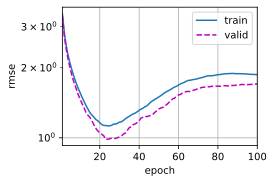

In [68]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 10, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')
#400显然过拟合了

In [ ]:
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse：{float(train_ls[-1]):f}')
    # 将网络应用于测试集。
    preds = net(test_features).detach().numpy()
    # 将其重新格式化以导出到Kaggle
    test_data['Sold Price'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)

In [39]:
# data=pd.read_csv('submission.csv')
# data.columns=['Id','Sold Price']
# data.to_csv('submission.csv',index=False)